<a href="https://colab.research.google.com/github/yastika/MscFE_Capstone/blob/dev_M4_resubmission/Climate_FinTech_(Simulation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SETUP & DATA GENERATION**

In [1]:
# Install required packages
!pip install plotly shap ipywidgets -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import json
import geopandas as gpd
import requests
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score, f1_score, mean_squared_error, roc_curve
import shap
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output
from plotly.subplots import make_subplots

# Suppress warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00


**SIMULATE ENVIRONMENTAL DATA**

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# List of states/UTs
states = [
    'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh',
    'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jharkhand',
    'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
    'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
    'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura',
    'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi', 'Jammu and Kashmir',
    'Ladakh', 'Puducherry', 'Chandigarh', 'Andaman and Nicobar Islands',
    'Dadra and Nagar Haveli and Daman and Diu', 'Lakshadweep'
]

# Approximate centroids for each state/UT
state_centroids = {
    'Andhra Pradesh':              (15.9129, 79.7400),
    'Arunachal Pradesh':           (28.2180, 94.7278),
    'Assam':                       (26.2006, 92.9376),
    'Bihar':                       (25.0961, 85.3131),
    'Chhattisgarh':                (21.2951, 81.8282),
    'Goa':                         (15.2993, 74.1240),
    'Gujarat':                     (22.2587, 71.1924),
    'Haryana':                     (29.0588, 76.0856),
    'Himachal Pradesh':            (31.1048, 77.1734),
    'Jharkhand':                   (23.6102, 85.2799),
    'Karnataka':                   (15.3373, 75.7139),
    'Kerala':                      (10.8505, 76.2711),
    'Madhya Pradesh':              (22.9734, 78.6569),
    'Maharashtra':                 (19.7515, 75.7139),
    'Manipur':                     (24.6637, 93.9063),
    'Meghalaya':                   (25.4670, 91.3662),
    'Mizoram':                     (23.1645, 92.9376),
    'Nagaland':                    (26.1584, 94.5624),
    'Odisha':                      (20.9517, 85.0985),
    'Punjab':                      (31.1471, 75.3412),
    'Rajasthan':                   (27.0238, 73.5714),
    'Sikkim':                      (27.5330, 88.5122),
    'Tamil Nadu':                  (11.1271, 78.6569),
    'Telangana':                   (18.1124, 79.0193),
    'Tripura':                     (23.9408, 91.9882),
    'Uttar Pradesh':               (26.8467, 80.9462),
    'Uttarakhand':                 (30.0668, 79.0193),
    'West Bengal':                 (22.9868, 87.8550),
    'Delhi':                       (28.7041, 77.1025),
    'Jammu and Kashmir':           (33.7782, 76.5762),
    'Ladakh':                      (34.1526, 77.5770),
    'Puducherry':                  (11.9416, 79.8083),
    'Chandigarh':                  (30.7333, 76.7794),
    'Andaman and Nicobar Islands': (11.7401, 92.6586),
    'Dadra and Nagar Haveli and Daman and Diu': (20.1809, 73.0169),
    'Lakshadweep':                 (10.3280, 72.7849)
}

# Simulate each state with one district
district_ids = [f'D{str(i).zfill(2)}' for i in range(1, 37)]
state_assignments = states

# Add small jitter to each centroid for district coordinates
coords = []
for state in state_assignments:
    lat, lon = state_centroids[state]
    lat += np.random.uniform(-0.1, 0.1)
    lon += np.random.uniform(-0.1, 0.1)
    coords.append((lat, lon))

# Define the time range
years = list(range(2000, 2016))

# Generate synthetic environmental data
data = []
for year in years:
    for i, district in enumerate(district_ids):
        state = state_assignments[i]
        lat, lon = coords[i]

        # Simulate values
        pm25 = np.random.uniform(30, 150)
        land_temp = np.random.uniform(25, 45)
        vegetation_stress = np.random.uniform(0.2, 1.0)
        flood_freq = np.random.randint(0, 6)

        # Append to dataset
        data.append({
            'year': year,
            'district_id': district,
            'state': state,
            'lat': lat,
            'lon': lon,
            'PM2.5': pm25,
            'LandTemp': land_temp,
            'VegetationStress': vegetation_stress,
            'FloodFreq': flood_freq
        })

# Create DataFrame
env_df = pd.DataFrame(data)

# Normalize features
scaler = MinMaxScaler()
env_df[['PM2.5', 'LandTemp', 'VegetationStress', 'FloodFreq']] = scaler.fit_transform(
    env_df[['PM2.5', 'LandTemp', 'VegetationStress', 'FloodFreq']]
)

# Compute Environmental Risk Index (ERI)
env_df['ERI'] = (
    0.4 * env_df['FloodFreq'] +
    0.3 * env_df['LandTemp'] +
    0.3 * env_df['VegetationStress']
)

# Display the DataFrame head to ensure correct structure
env_df.head()

,year,district_id,state,lat,lon,PM2.5,LandTemp,VegetationStress,FloodFreq,ERI
0,2000,D01,Andhra Pradesh,15.887808,79.830143,0.002941,0.817790,0.709188,0.4,0.618094
1,2000,D02,Arunachal Pradesh,28.264399,94.747532,0.791423,0.607605,0.929705,0.2,0.541193
2,2000,D03,Assam,26.131804,92.868799,0.113827,0.865588,0.625221,0.2,0.527243
3,2000,D04,Bihar,25.007717,85.386335,0.093268,0.371695,0.670986,0.8,0.632805
4,2000,D05,Chhattisgarh,21.315323,81.869815,0.730558,0.639305,0.890426,0.0,0.458919


**SIMULATE FINANCIAL DATA**

In [3]:
# Simulate Financial Data for the Indian districts
sme_df = pd.DataFrame({
    'sme_id': [f'SME{i}' for i in range(1, 1001)],
    'district_id': np.random.choice(district_ids, size=1000),
    'year': np.random.choice(years, size=1000),  # Random year between 2000 and 2015
    'LoanSize': np.random.uniform(10000, 1000000, size=1000),
    'InterestRate': np.random.uniform(5, 30, size=1000),
    'CashFlow': np.random.uniform(10000, 300000, size=1000),
    'DebtToEquity': np.random.uniform(0.1, 3.0, size=1000),
    'FirmSize': np.random.randint(5, 200, size=1000),
    'FirmAge': np.random.randint(1, 25, size=1000),
    'Default': np.random.choice([0, 1], size=1000, p=[0.8, 0.2])
})

# Merge SME financial data with environmental data based on district_id and year
df = pd.merge(sme_df, env_df[['district_id', 'year', 'ERI']], on=['district_id', 'year'])

# Display the head of the merged DataFrame to check the result
df.head()

,sme_id,district_id,year,LoanSize,InterestRate,CashFlow,DebtToEquity,FirmSize,FirmAge,Default,ERI
0,SME1,D04,2012,377752.589998,12.814951,47221.478718,2.149730,194,7,0,0.268339
1,SME2,D25,2003,203214.852046,15.267066,198554.278269,2.768111,72,21,0,0.641845
2,SME3,D15,2000,494498.612033,10.242257,294919.948374,0.884982,96,5,0,0.514538
3,SME4,D21,2002,744225.037318,29.414026,274427.385166,1.174425,129,4,0,0.732088
4,SME5,D35,2009,497643.380046,21.140064,137347.891633,1.749872,175,22,0,0.535261


**FEATURE ENGINEERING & MERGE**

In [4]:
df['Loan_to_CashFlow'] = df['LoanSize'] / df['CashFlow']

features = [
    'LoanSize', 'InterestRate', 'CashFlow', 'DebtToEquity',
    'FirmSize', 'FirmAge', 'ERI', 'Loan_to_CashFlow'
]
X = df[features]
y = df['Default']

**MODEL TRAINING AND HYPERPARAMETER TUNING**

In [5]:
# ---- Data Split & Model Training ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)

**MODEL EVALUATION METRICS**

Root Mean Square Error (RMSE): 0.3733
AUC-ROC Score: 0.5386
Precision: 0.3750
Recall: 0.1034
F1 Score: 0.1622

Classification Report (default threshold):
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       171
           1       0.38      0.10      0.16        29

    accuracy                           0.84       200
   macro avg       0.62      0.54      0.54       200
weighted avg       0.79      0.84      0.81       200



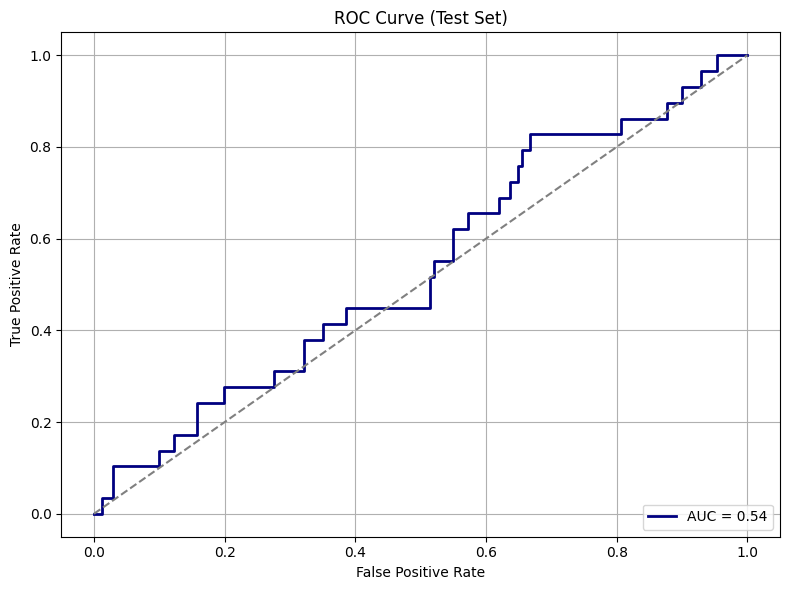


📊 Cross-Validation Performance Metrics (5-Fold):
Root Mean Square Error (CV): 0.4119
AUC-ROC Score (CV): 0.4861
Precision (CV): 0.1111
Recall (CV): 0.0163
F1 Score (CV): 0.0284

Classification Report (5-Fold Cross-Validation):
               precision    recall  f1-score   support

           0       0.81      0.97      0.89       816
           1       0.11      0.02      0.03       184

    accuracy                           0.80      1000
   macro avg       0.46      0.49      0.46      1000
weighted avg       0.68      0.80      0.73      1000



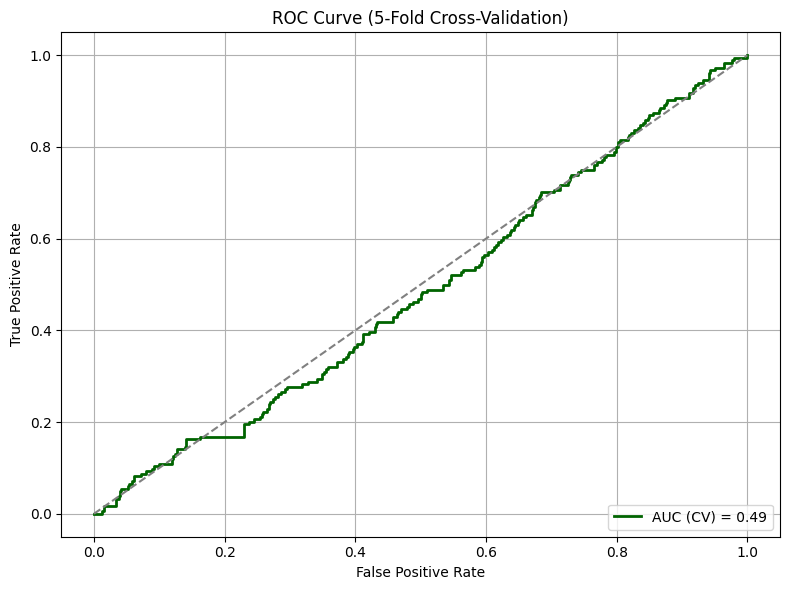

In [6]:
# ---- Probabilistic Fit Assessment: RMSE ----
rmse = np.sqrt(mean_squared_error(y_test, y_probs))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# ---- Threshold-Independent Metric: AUC-ROC ----
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC Score: {auc_score:.4f}")

# ---- Threshold-Based Metrics ----
y_pred = (y_probs >= 0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ---- Classification Report ----
print("\nClassification Report (default threshold):\n", classification_report(y_test, y_pred))

# ---- ROC Curve Visualization (Test Set) ----
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='navy', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Cross-Validation Evaluation (5-Fold) ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_cv_probs = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
y_cv_pred = (y_cv_probs >= 0.5).astype(int)

print("\n📊 Cross-Validation Performance Metrics (5-Fold):")
rmse_cv = np.sqrt(mean_squared_error(y, y_cv_probs))
auc_cv = roc_auc_score(y, y_cv_probs)
precision_cv = precision_score(y, y_cv_pred)
recall_cv = recall_score(y, y_cv_pred)
f1_cv = f1_score(y, y_cv_pred)

print(f"Root Mean Square Error (CV): {rmse_cv:.4f}")
print(f"AUC-ROC Score (CV): {auc_cv:.4f}")
print(f"Precision (CV): {precision_cv:.4f}")
print(f"Recall (CV): {recall_cv:.4f}")
print(f"F1 Score (CV): {f1_cv:.4f}")

print("\nClassification Report (5-Fold Cross-Validation):\n", classification_report(y, y_cv_pred))

# ---- ROC Curve Visualization for CV ----
fpr_cv, tpr_cv, _ = roc_curve(y, y_cv_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, label=f"AUC (CV) = {auc_cv:.2f}", color='darkgreen', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (5-Fold Cross-Validation)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**SHAP MODEL INTERPRETABILITY**

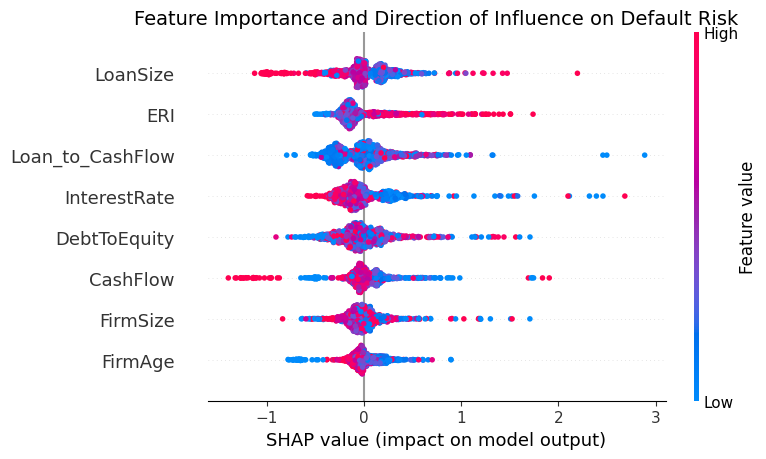

In [7]:
# Create SHAP explainer and values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Create SHAP plot to it
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, show=False)
plt.title("Feature Importance and Direction of Influence on Default Risk", fontsize=14)
plt.tight_layout()
plt.show()

**CLIMATE-ADJUSTED CREDIT SCORING**

In [8]:
df['CreditRiskScore'] = model.predict_proba(X)[:, 1]
px.histogram(df, x='CreditRiskScore', nbins=30, title='Climate-Adjusted Credit Risk Scores')

**GEOSPATIAL VISUALIZATION (HOTSPOTS)**

In [9]:
# Merge df with env_df to get 'state', 'lat', and 'lon'
merged_df = pd.merge(df, env_df[['district_id', 'state', 'lat', 'lon']], on='district_id')

# Group by district and state to compute mean CreditRiskScore per district
district_scores = merged_df.groupby(['district_id', 'state', 'lat', 'lon'])['CreditRiskScore'].mean().reset_index()

# Create hover label with district and state
district_scores['hover_label'] = '<b>' + district_scores['district_id'] + ', ' + district_scores['state'] + '</b>'

# Create the main plot
fig = px.scatter_geo(
    district_scores,
    lat='lat', lon='lon',
    size='CreditRiskScore',
    color='CreditRiskScore',
    hover_name='hover_label',
    title='District-Level Average Credit Risk Scores',
    projection="mercator"
)

# Add district and state labels with jittered positions to reduce overlap
np.random.seed(42)
lat_jitter = np.random.uniform(-0.2, 0.2, size=len(district_scores))
lon_jitter = np.random.uniform(-0.2, 0.2, size=len(district_scores))

district_label_traces = []
for i, row in district_scores.iterrows():
    label_text = f"<b>{row['district_id']}, {row['state']}</b>"
    jittered_lat = row['lat'] + lat_jitter[i]
    jittered_lon = row['lon'] + lon_jitter[i]
    district_label_traces.append(go.Scattergeo(
        lat=[jittered_lat], lon=[jittered_lon],
        text=[label_text],
        mode='text',
        textfont=dict(size=10, color='black', family='Arial'),
        showlegend=False,
        hoverinfo='skip'
    ))

# Add labels to figure
for trace in district_label_traces:
    fig.add_trace(trace)

# Auto fit to all data points
fig.update_geos(
    showcountries=True,
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="lightblue",
    fitbounds="locations",  # Auto fit all district points
    resolution=50
)

# Layout settings
fig.update_layout(
    width=1100,
    height=850,
    geo=dict(
        scope="world",
        projection=dict(type="mercator")
    ),
    margin={"r": 10, "t": 40, "l": 10, "b": 40}
)

fig.show()

**FEATURE DISTRIBUTION VISUALIZATIONS**

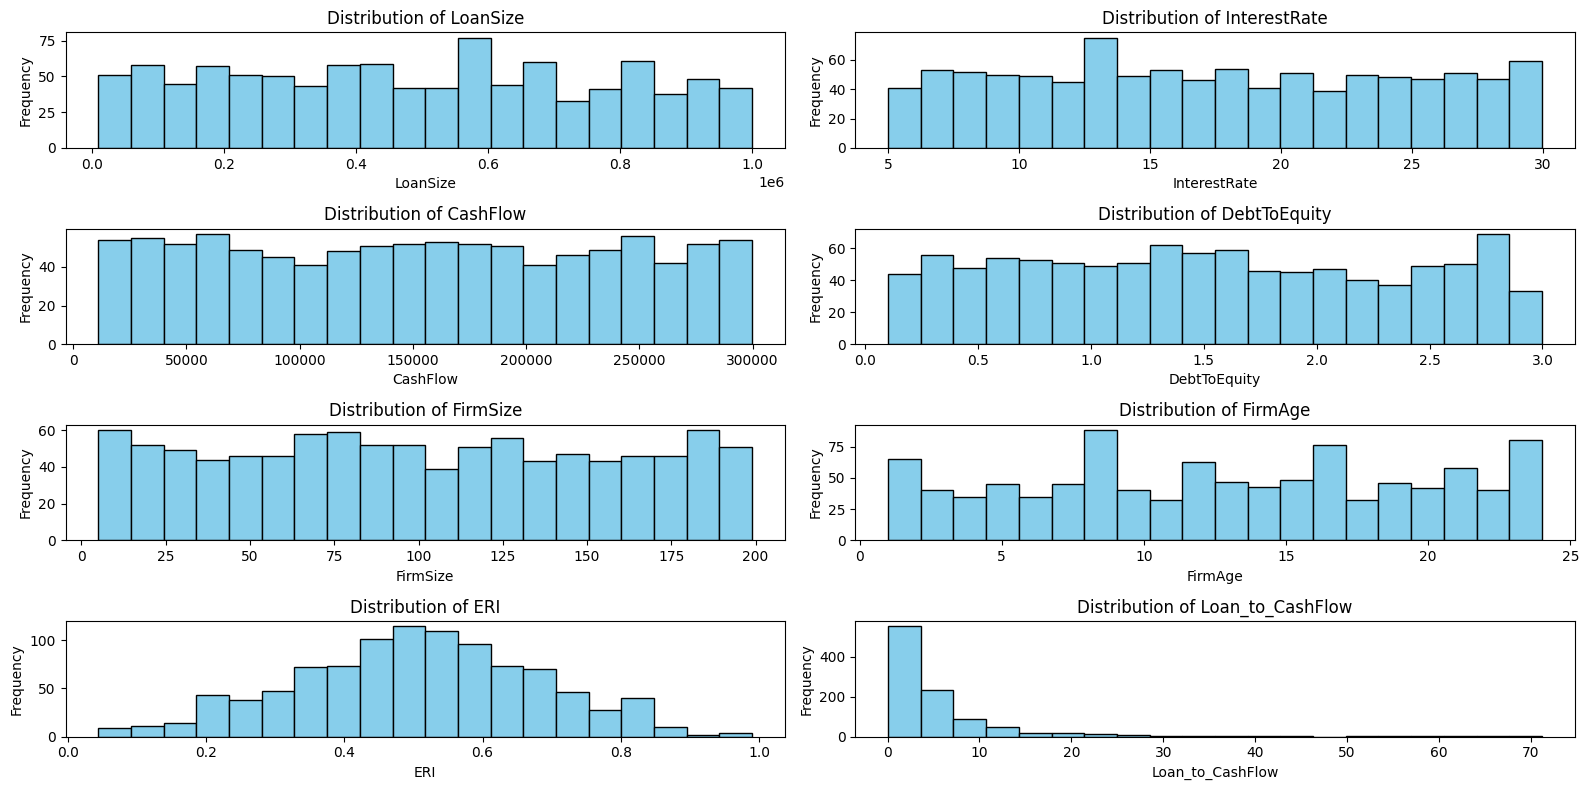

In [10]:
# Input Feature Distribution Visualization
# Plot histograms for each input feature to show the distribution

def plot_feature_distributions(df, features):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 8))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        axes[i].hist(df[feature], bins=20, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Visualize input feature distributions
plot_feature_distributions(df, features)

**SLIDER CREDIT DEFAULT PREDICTION**

In [11]:
# Slider Widgets for Input Features
sliders = {
    'LoanSize': widgets.FloatSlider(min=10000, max=1000000, step=10000, value=200000, description='Loan Size'),
    'InterestRate': widgets.FloatSlider(min=5, max=30, step=0.5, value=10, description='Interest Rate'),
    'CashFlow': widgets.FloatSlider(min=10000, max=300000, step=10000, value=50000, description='Cash Flow'),
    'DebtToEquity': widgets.FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0, description='Debt to Equity'),
    'FirmSize': widgets.IntSlider(min=5, max=200, step=5, value=50, description='Firm Size'),
    'FirmAge': widgets.IntSlider(min=1, max=25, step=1, value=10, description='Firm Age'),
    'ERI': widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='ERI'),
}

gauge_output = widgets.Output()
shap_output = widgets.Output()

def predict_risk(change=None):
    kwargs = {k: slider.value for k, slider in sliders.items()}

    row = pd.DataFrame([[
        kwargs['LoanSize'], kwargs['InterestRate'], kwargs['CashFlow'], kwargs['DebtToEquity'],
        kwargs['FirmSize'], kwargs['FirmAge'], kwargs['ERI'], kwargs['LoanSize'] / kwargs['CashFlow']
    ]], columns=features)

    prob = model.predict_proba(row)[0, 1]

    with gauge_output:
        gauge_output.clear_output(wait=True)
        fig = go.Figure(go.Indicator(
            mode="gauge+number",
            value=prob,
            title={'text': "Predicted Default Probability"},
            gauge={
                'axis': {'range': [0, 1]},
                'bar': {'color': "darkred"},
                'steps': [
                    {'range': [0, 0.3], 'color': "lightgreen"},
                    {'range': [0.3, 0.7], 'color': "orange"},
                    {'range': [0.7, 1.0], 'color': "red"}
                ]
            }
        ))
        fig.update_layout(height=350, margin=dict(t=30, b=10))
        fig.show()

    with shap_output:
        shap_output.clear_output(wait=True)
        shap_value = explainer(row)
        plt.figure(figsize=(10, 4))
        shap.plots.waterfall(shap_value[0], show=False)
        plt.title(f"Prediction Probability = f(x) | Baseline = E[f(x)]")
        plt.tight_layout()
        plt.show()

# Attach update triggers to sliders
for slider in sliders.values():
    slider.observe(predict_risk, names='value')

# Initial run
predict_risk()

# Layout and display
predict_widgets = widgets.VBox([
    widgets.VBox(list(sliders.values())),
    widgets.HBox([gauge_output, shap_output])
])
display(predict_widgets)

**ACTIONABLE INSIGHTS REPORT (PRINTOUT)**

KEY DISTRICT-LEVEL INSIGHTS:
- District D31: Avg. Credit Risk Score = 0.11 (🟢 Low Risk)
- District D15: Avg. Credit Risk Score = 0.14 (🟢 Low Risk)
- District D19: Avg. Credit Risk Score = 0.15 (🟢 Low Risk)
- District D12: Avg. Credit Risk Score = 0.15 (🟢 Low Risk)
- District D17: Avg. Credit Risk Score = 0.15 (🟢 Low Risk)
- District D07: Avg. Credit Risk Score = 0.15 (🟢 Low Risk)
- District D20: Avg. Credit Risk Score = 0.16 (🟢 Low Risk)
- District D21: Avg. Credit Risk Score = 0.16 (🟢 Low Risk)
- District D27: Avg. Credit Risk Score = 0.16 (🟢 Low Risk)
- District D26: Avg. Credit Risk Score = 0.17 (🟢 Low Risk)
- District D34: Avg. Credit Risk Score = 0.17 (🟢 Low Risk)
- District D11: Avg. Credit Risk Score = 0.17 (🟢 Low Risk)
- District D32: Avg. Credit Risk Score = 0.17 (🟢 Low Risk)
- District D25: Avg. Credit Risk Score = 0.17 (🟢 Low Risk)
- District D10: Avg. Credit Risk Score = 0.18 (🟢 Low Risk)
- District D23: Avg. Credit Risk Score = 0.18 (🟢 Low Risk)
- District D09: Avg. Credit

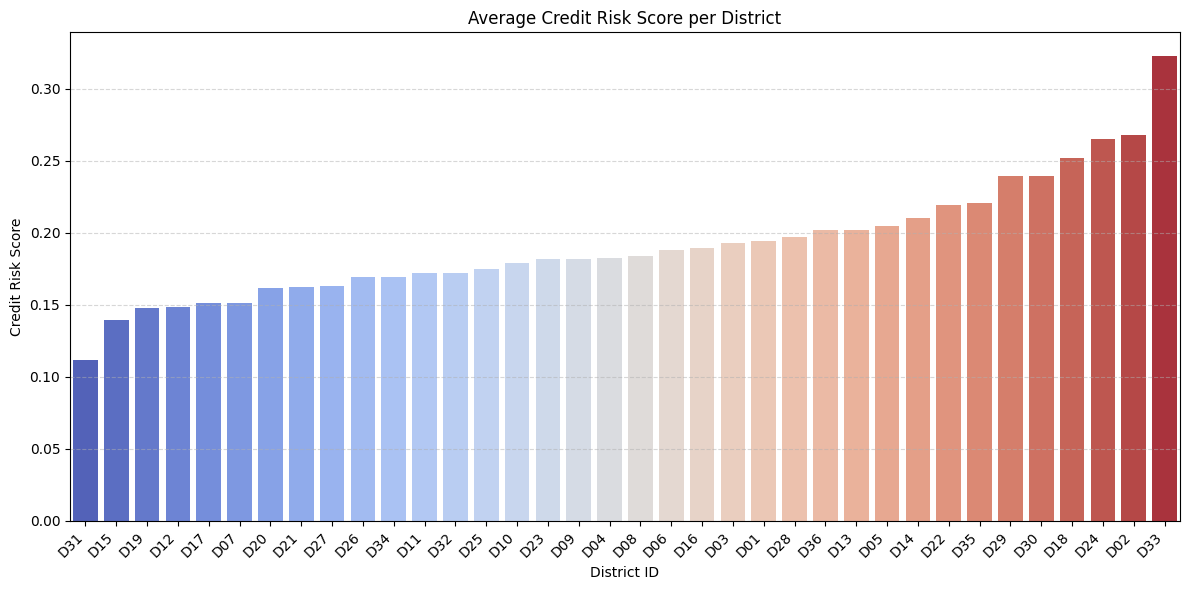

In [12]:
# Ensure missing values for 'district_id' and 'CreditRiskScore'
df = df.dropna(subset=['district_id', 'CreditRiskScore'])

# Compute average CreditRiskScore per district
district_summary = df.groupby('district_id')['CreditRiskScore'].mean().sort_values(ascending=True)

# Print key insights from low to high risk
print("KEY DISTRICT-LEVEL INSIGHTS:")
for district, avg_risk in district_summary.items():
    if avg_risk > 0.7:
        risk_level = "🔴 High Risk"
    elif avg_risk > 0.3:
        risk_level = "🟠 Moderate Risk"
    else:
        risk_level = "🟢 Low Risk"

    print(f"- District {district}: Avg. Credit Risk Score = {avg_risk:.2f} ({risk_level})")

# Recommendations: Top 3 risky districts (highest scores)
top_risk_districts = district_summary.sort_values(ascending=False).head(3)

print("\n📌 RECOMMENDATION:")
print("- Consider credit tightening or targeted support in top 3 higher-risk districts:")
print(", ".join(top_risk_districts.index.astype(str)))

# Plot average CreditRiskScore per district
plt.figure(figsize=(12, 6))
sns.barplot(x=district_summary.index.astype(str), y=district_summary.values, palette='coolwarm')
plt.title("Average Credit Risk Score per District")
plt.xlabel("District ID")
plt.ylabel("Credit Risk Score")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**FEATURE FREQUENCY RELATIONSHIP FROM THE YEARS 2000 THROUGH TO 2015**

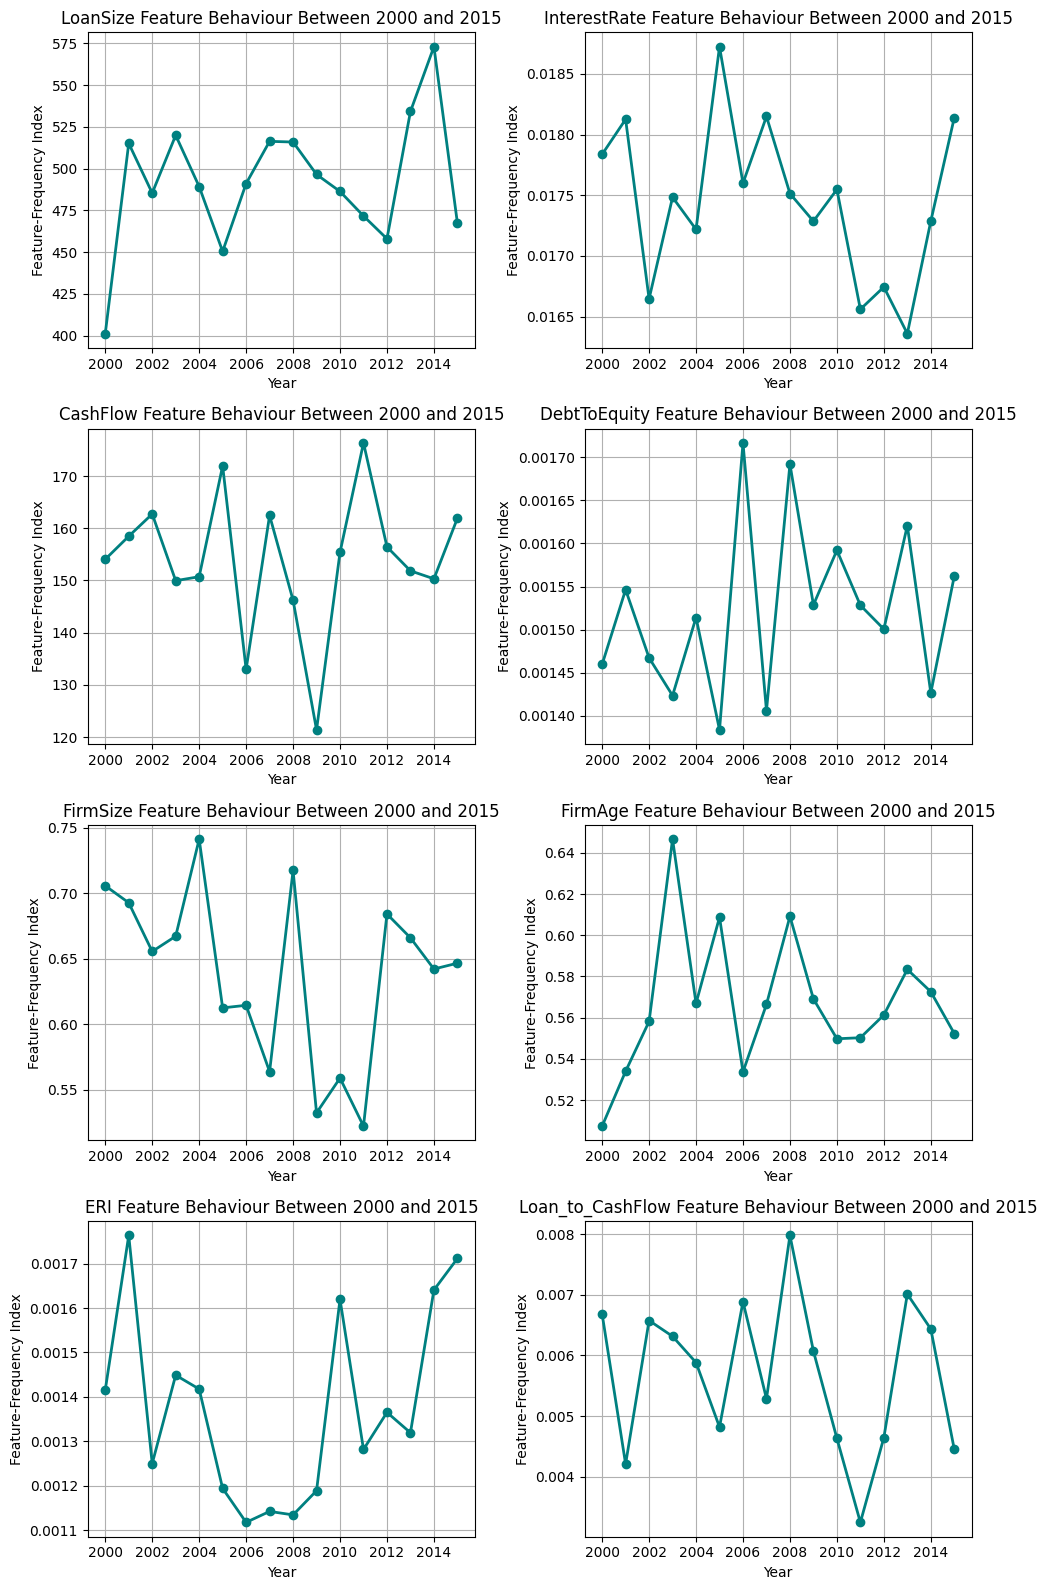

In [13]:
# Filter data for the years 2000 to 2015
df_filtered = df[df['year'].between(2000, 2015)]

# Define number of rows and columns
rows = 4
cols = 2

# Create a subplot grid of 4 rows and 2 columns
fig, axes = plt.subplots(rows, cols, figsize=(10, 16))

# Flatten axes array to iterate over it easily
axes = axes.flatten()

# Iterate through the features and plot the feature-frequency relationship
for i, feature in enumerate(features):
    # Calculate the frequency of each feature value
    feature_counts = df_filtered[feature].value_counts(normalize=True)

    # Multiply the feature values by their frequencies to create a feature-frequency relationship
    feature_freq_param = df_filtered[feature].apply(lambda x: x * feature_counts.get(x, 0))

    # Aggregate the feature-frequency parameter by year
    yearly_param = df_filtered.groupby('year').apply(lambda x: (x[feature].apply(lambda y: y * feature_counts.get(y, 0))).mean())

    # Plot the feature-frequency relationship against the years
    axes[i].plot(yearly_param.index, yearly_param.values, marker='o', color='teal', linewidth=2)
    axes[i].set_title(f'{feature} Feature Behaviour Between 2000 and 2015', fontsize=12)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Feature-Frequency Index')
    axes[i].grid(True)

# Adjust the layout of the subplots for better readability
plt.tight_layout()
plt.show()